# Анализ продаж игр для интернет-магазина "Стримчик"

Цели и задачи проекта:
Проанализировав исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы, выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании интернет-магазина.

Описание данных

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

План исследования:
1. [Ознакомление с данными](#start)
    - [Загрузка данных](#1.1) 
    - [Изучение общей информации о датасетах](#1.2)
    - [Визуализация пропущенных значений](#1.3)
2. [Предобработка данных](#preprocessing) 
    - [Приведение названия столбцов к нижнему регистру](#2.1)
    - [Изменения типа данных](#2.2) 
    - [Обработка столбца user_score](#2.3)
    - [Обработка столбца name](#2.4)
    - [Обработка столбца rating ](#2.5)
    - [Добавление нового столбца total_sales](#2.6)
    - [Вывод по разделу](#2.7)
3. [Исследовательский анализ данных](#analitic)
    - [Сколько игр выпускалось в разные годы](#3.1) 
    - [Как менялись продажи по платформам](#3.2)
    - [Выбор актуального периода](#3.3)
    - [Платфоры — лидеры по продажам](#3.4)
    - [«Ящик с усами» по глобальным продажам игр в разбивке по платформам ](#3.5) 
    - [Влияние на продажи отзывов пользователей и критиков](#3.6)
    - [Распределение игр по жанрам по количеству и по сумме продаж](#3.7)
    - [Вывод по разделу исследователького анализа](#3.8)
4. [Портрет пользователя](#anal)
    - [Самые популярные платформы (топ-5)](#4.1)
    - [Самые популярные жанры (топ-5) ](#4.2) 
    - [Влияние рейтинга ESRB на продажи в отдельном регионе ](#4.3)
    - [Вывод по разделу](#4.4)    
5. [Проверка гипотез](#gypo)
    - [ Средние пользовательские рейтинги платформ ](#5.1)
    - [Средние пользовательские рейтинги жанров](#5.2) 
6. [Общий вывод](#end)


<a id="start"></a>
Загрузим необходимые библиотеки

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', '{:,.2f}'.format)
import plotly.express as px
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import scipy.stats as st
!pip install missingno
import missingno as msno

<a id="1.1"></a>
## Загрузка данных

In [2]:
# загружаем датафрейм
try:
    data = pd.read_csv('/datasets/games.csv')

except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

<a id="1.2"></a>
Посмотрим на наши данные, для этого используем функцию.

In [3]:
def show_info(data):
    display(data.head())
    
    # Описательные статистики для категориальных признаков
    cat_data = data.select_dtypes(include='object')
    for col in cat_data.columns:
        print(f"Уникальные значения для {col}: {data[col].unique()}")
    
    # Описательные статистики для числовых признаков
    num_data = data.select_dtypes(include=['int64', 'float64'])
    if not num_data.empty:
        display(num_data.describe().T)
    
    print(data.info())
    print("Проверка на пропуски:")
    display(data.isnull().sum())
    
    # Проверка на дубликаты
    print("Проверка на дубликаты:")
    if (duplicated := data.duplicated(keep=False)).any():
        some_duplicates = data[duplicated].sort_values(by=data.columns.to_list()).head()
        print(f"DataFrame содержит одну или несколько дублирующихся строк, например:\n{some_duplicates}")
    else:
        print("В DataFrame нет дублирующихся строк.")

In [4]:
show_info(data)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Уникальные значения для Name: ['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ...
 'Woody Woodpecker in Crazy Castle 5' 'LMA Manager 2007'
 'Haitaka no Psychedelica']
Уникальные значения для Platform: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
Уникальные значения для Genre: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan]
Уникальные значения для User_Score: ['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7'

,count,mean,std,min,25%,50%,75%,max
Year_of_Release,"16,446.00","2,006.48",5.88,"1,980.00","2,003.00","2,007.00","2,010.00","2,016.00"
NA_sales,"16,715.00",0.26,0.81,0.00,0.00,0.08,0.24,41.36
EU_sales,"16,715.00",0.15,0.50,0.00,0.00,0.02,0.11,28.96
JP_sales,"16,715.00",0.08,0.31,0.00,0.00,0.00,0.04,10.22
Other_sales,"16,715.00",0.05,0.19,0.00,0.00,0.01,0.03,10.57
Critic_Score,"8,137.00",68.97,13.94,13.00,60.00,71.00,79.00,98.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None
Проверка на пропуски:


Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Проверка на дубликаты:
В DataFrame нет дублирующихся строк.


<a id="1.3"></a>
Визуализируем информацию о пропусках

<AxesSubplot:>

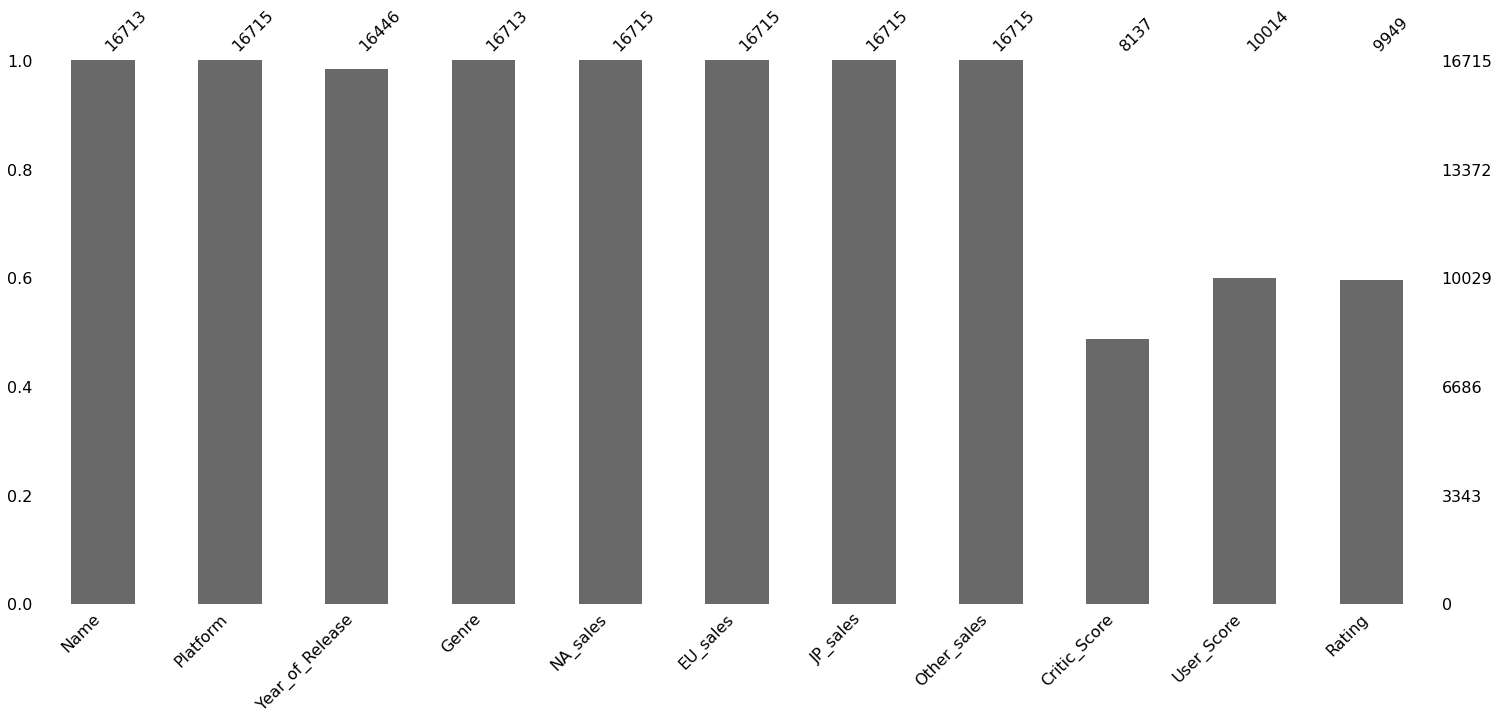

In [5]:
msno.bar(data)

Мы сразу видим, какие переменные полны, а в каких много пропусков (Critic_Score, User_Score,Rating)    

Посмотрим на корреляцию недействительных показателей тепловой карты: насколько сильно присутствие или отсутствие одной переменной влияет на существование другой.

<AxesSubplot:>

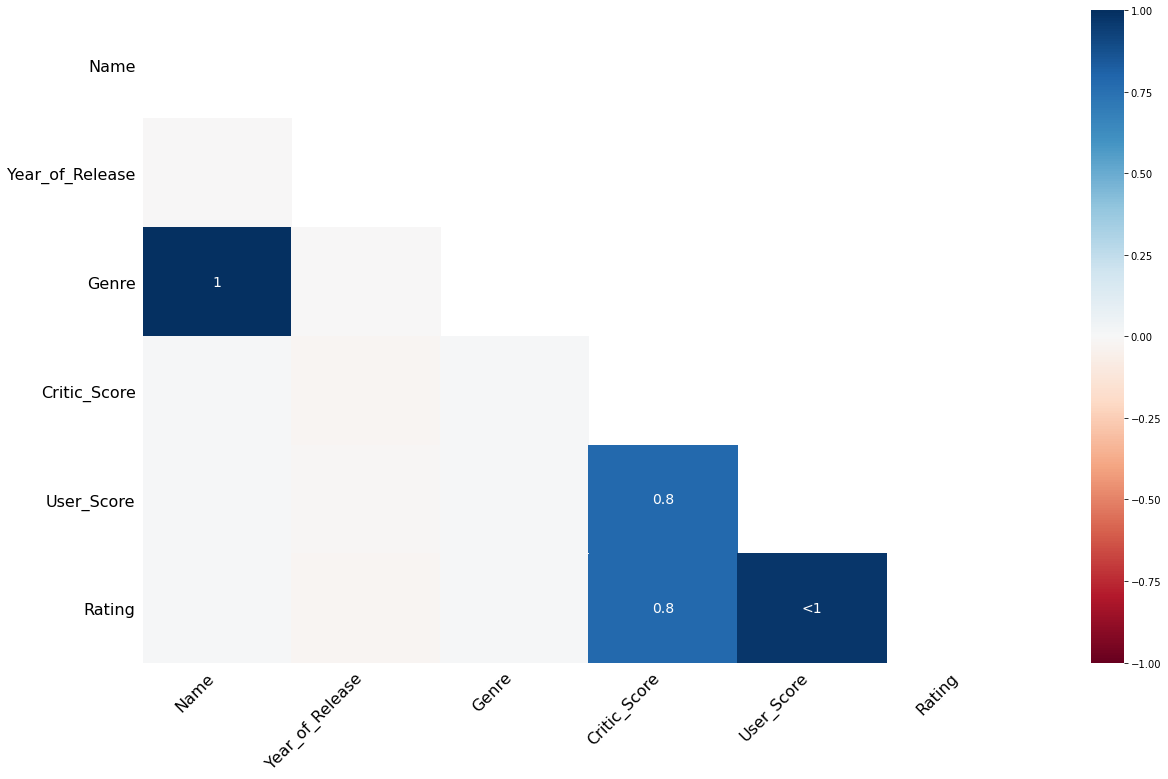

In [6]:
 msno.heatmap(data)

Мы видим, что корреляция между удалением Genre и Name равна 1, что указывает на то, если удалить пропуски в Genre, то и строки с пропусками в Name удаляться.
Корреляция между Critic_Score и User_Score, и также между Critic_Score и Rating равна 0.8, что означает, большинство пропущенных значений User_Score и Rating удалиться вместе с удалением пропущенных значений Critic_Score. При удалении пропущенных значений User_Score так же удаляться все пропущенные значения Rating.

В нашем датасете 11 столбцов и 16713 строк. В столбцах Name, Genre, Year_of_Release, Critic_Score, User_Score, Rating есть пропуски, что мы будем делать с ними решим дальше. Не всех типы данных соответствуют нужным, а именно Year_of_Release (float64) и  User_Score (object), их нужно поменять.                   

<a id="preprocessing"></a> 
## Предобработка данных

<a id="2.1"></a>
Для начала приведем названия столбцов к змеиному регистру

In [7]:
data.columns = data.columns.str.lower()

<a id="2.2"></a>
Изменим тип данных у столбца Year_of_Release на целое число, так как год - это всегда число целое.

In [8]:
data['year_of_release'] = pd.array(data['year_of_release'], dtype = pd.Int64Dtype())


Посмотрим за какие года представлены данные

In [9]:
data['year_of_release'].min()

1980

In [10]:
data['year_of_release'].max()

2016

Данные представлены с 1980 по 2016 год. Так же мы видим, что у нас 269 пропусков в данном столбце. Заменить нам данные пропуски не представляется возможным, оставим их как есть, возможно это техническая ошибка.

<a id="2.3"></a>
Посмотрим на количество уникальных значений столбца user_score         

In [11]:
data['user_score'].value_counts(dropna=False)

NaN    6701
tbd    2424
7.8     324
8       290
8.2     282
       ... 
9.6       2
1         2
1.3       2
0         1
9.7       1
Name: user_score, Length: 97, dtype: int64

Всего значений в столбце user_score у нас 10014, из них 6701 пропуски и 2424 значений  tbd (Значение 'tbd' обычно означает "To Be Determined" (будет определено) и часто используется в игровой индустрии для обозначения того, что рейтинг еще не установлен). Изменим значение tbd на NaN  и поменяем тип данных столбца на float.

In [12]:
# Заменяем 'tbd' на NaN в столбце user_score
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

Так же мы видим в столбце user_score пропуски. Заполнить их сами мы не можем, оставим их как есть.

<a id="2.4"></a>
Изучим уникальные значения столбца name

In [13]:
data['name'].value_counts(dropna=False).head(30)

Need for Speed: Most Wanted                    12
FIFA 14                                         9
Madden NFL 07                                   9
LEGO Marvel Super Heroes                        9
Ratatouille                                     9
LEGO Jurassic World                             8
Cars                                            8
The LEGO Movie Videogame                        8
Madden NFL 08                                   8
Lego Batman 3: Beyond Gotham                    8
LEGO Harry Potter: Years 5-7                    8
FIFA Soccer 13                                  8
Monopoly                                        8
Terraria                                        8
LEGO Star Wars II: The Original Trilogy         8
LEGO The Hobbit                                 8
Angry Birds Star Wars                           8
FIFA 15                                         8
Skylanders: SuperChargers                       7
Harry Potter and the Half-Blood Prince          7


Приведем названия в столбце name к нижнему регистру

In [14]:
data['name'] = data['name'].str.lower()  # Приведение всех значений к нижнему регистру


Посмотрим, почему у нас названия игр не уникальны

In [15]:
data_name_cars = data.query("name == 'cars'")
data_name_cars

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1651,cars,PS2,2006,Racing,1.01,0.04,0.00,0.16,71.00,8.40,E
1685,cars,PSP,2006,Racing,0.72,0.28,0.00,0.20,70.00,7.00,E
1805,cars,GBA,2006,Racing,0.81,0.30,0.00,0.02,50.00,4.70,E
2127,cars,DS,2006,Racing,0.85,0.04,0.00,0.07,54.00,2.10,E
2227,cars,GC,2006,Racing,0.72,0.19,0.00,0.03,71.00,7.00,E
2244,cars,Wii,2006,Racing,0.83,0.03,0.00,0.07,65.00,NaN,E
6668,cars,X360,2006,Racing,0.22,0.01,0.00,0.02,65.00,6.10,E
7567,cars,XB,2006,Racing,0.15,0.04,0.00,0.01,70.00,NaN,E


Одна игра выходит на разных платформах - отсюда и несколько записей 

Посмотрим в каких строках пропущено значение столбца name

In [16]:
data_name_nan = data[data['name'].isnull()]
data_name_nan

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Мы видим, что в этих строках так же отсутствует значение genre,critic_score,user_score, rating поэтому удалим эти строки

In [17]:
data.dropna(subset=['name'], inplace=True)

<a id="2.5"></a>
Посмотрим на значения столбца rating 

In [18]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Рейтинг от организации ESRB (англ. Entertainment Software Rating Board) определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. Заменим обозначения рейтинг на их значения для удобства восприятия

In [19]:
# Создание словаря для замены значений
rating_mapping = {'E': 'Для всех',
                  'M': 'Для взрослых',
                  'T': 'Подросткам',
                  'E10+': 'Для всех от 10 лет и старше',
                  'AO': 'Только для взрослых',
                  'EC': 'Для детей младшего возраста',
                  'RP': 'Рейтинг ожидается'}

# Замена значений в столбце 'rating'
data['rating'] = data['rating'].replace(rating_mapping)

Так в столбце rating есть пропуски, заполнить их сами мы не можем, так что оставим пока как есть.

Посмотри теперь на нашу таблицу

In [20]:
data.head(20)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,Для всех
1,super mario bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,Для всех
3,wii sports resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,Для всех
4,pokemon red/pokemon blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,new super mario bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.00,8.50,Для всех
7,wii play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.00,6.60,Для всех
8,new super mario bros. wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.00,8.40,Для всех
9,duck hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<a id="2.6"></a>
Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец total_sales.

In [21]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,Для всех,82.54
1,super mario bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,mario kart wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,Для всех,35.52
3,wii sports resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,Для всех,32.77
4,pokemon red/pokemon blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


<a id="2.7"></a>
На этапе предобработки мы заменили типы данных в столбцах user_score и year_of_release, привели название столбцов и значения столбца name к нижнему регистру. Изменили значения столбца rating для наглядности дальнейшего анализа. Так же мы добавили новый столбец rating с суммарными продажами по играм во всех регионах. Удалили 2 пропуска столбца name и genre, которые оказались в одних строках.  Проанализировав пропуски в остальных столбцах, пришли к выводу, что удалять их не будем, так как пока непонятно как они повлияют на дальнейший анализ. В случае необходимости сделаем это в процессе работы над проектом. 

<a id="analitic"></a> 
## Исследовательский анализ данных

<a id="3.1"></a>
Посмотрим, сколько игр выпускалось в разные годы. Для этого сгруппируем наши данные по году выпуска и подсчитаем количество.

In [22]:
games_per_year = data.groupby('year_of_release').size()

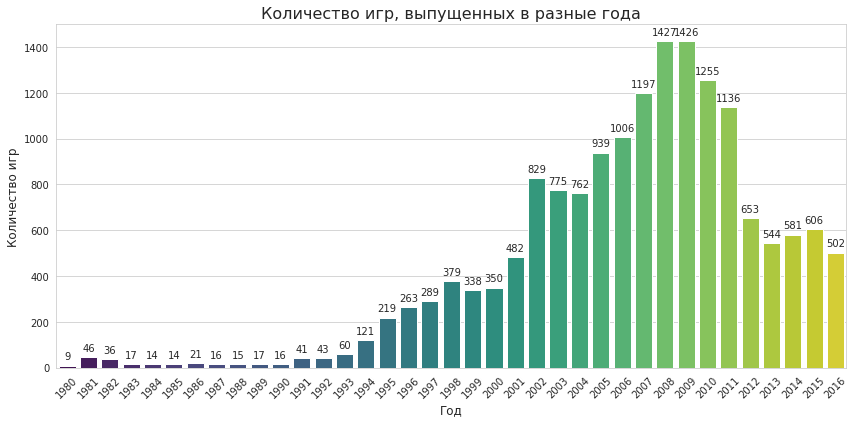

In [23]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")  # Устанавливаем стиль сетки
# Создаем график
ax = sns.barplot(x=games_per_year.index, y=games_per_year.values, palette="viridis")
# Добавляем заголовок и метки осей
plt.title('Количество игр, выпущенных в разные года', fontsize=16)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество игр', fontsize=12)

# Добавляем подписи на оси X под углом
plt.xticks(rotation=45)

# Добавляем значения над столбцами
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

На графике видно, что, за исключением небольшого роста в 1981-1982 годах, индустрия компьютерных игр "спала" вплоть до начала 1990-х годов. Далее идет рост количества выпускаемых игр и достигает своего пика 2008-2009 годах. После наблюдается довольно-таки резкий спад до менее чем половины значений к концу исследуемого периода. Целесообразным видится считать не важными для анализа данные до 1995 года.

<a id="3.2"></a>
Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 

Для этого сгруппируем данные по платформам и посчитаем общую сумму продаж для каждой и отсортируем по убыванию, выведем топ-6 платформ.

In [24]:
top_platform = data.groupby('platform')['total_sales'].count().sort_values(ascending=False).head(6)
top_platform

platform
PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
Name: total_sales, dtype: int64

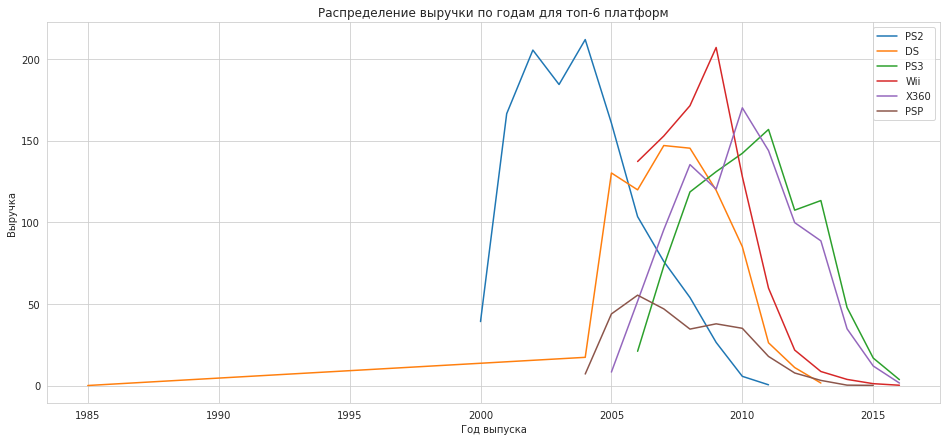

In [25]:
#Фильтрация данных
top_platform = top_platform.index.tolist() 
filtered_data = data[data['platform'].isin(top_platform)]

#Группировка и агрегация
sales_by_year_and_platform = filtered_data.groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()

#Визуализация
plt.figure(figsize=(16,7))
for platform in top_platform:
    platform_data = sales_by_year_and_platform[sales_by_year_and_platform['platform'] == platform]
    plt.plot(platform_data['year_of_release'], platform_data['total_sales'], label=platform)

plt.title('Распределение выручки по годам для топ-6 платформ')
plt.xlabel('Год выпуска')
plt.ylabel('Выручка')
plt.legend()
plt.show()

На графике видно, что каждая из платформ "живет" примерно 10 лет. Если обратить внимание на платформы PS, то наглядно видно, как каждая новая версия заменяет собой предыдущую. Только одна платформа DS на протяжении всего периода.

<a id="3.3"></a>
На основе анализа выпуска игр по годам и распределения выручки по годам,с учетом того, что сфера видеоигр развивается и меняется довольно-таки быстро, возьмем за актуальный период для построения прогноза на 2017 год период с 2012 по 2016 год (5 лет). Исключим данные за года, предыдущие 2012 году.

In [26]:
data_since_2012 = data.query("year_of_release > 2011").reset_index()
data_since_2012

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,16,grand theft auto v,PS3,2013,Action,7.02,9.09,0.98,3.96,97.00,8.20,Для взрослых,21.05
1,23,grand theft auto v,X360,2013,Action,9.66,5.14,0.06,1.41,97.00,8.10,Для взрослых,16.27
2,31,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,33,pokemon x/pokemon y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,34,call of duty: black ops ii,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.00,5.30,Для взрослых,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,16703,strawberry nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
2882,16707,aiyoku no eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
2883,16710,samurai warriors: sanada maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
2884,16712,haitaka no psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


<a id="3.4"></a>
Определим какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ. Для этого построим график распределения суммы продаж по платформам и годам выпуска.

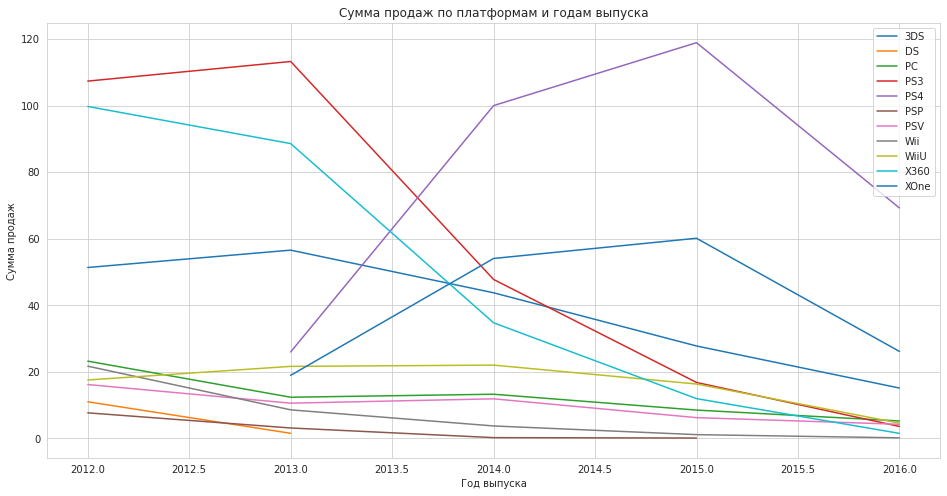

In [27]:
# Группировка данных по платформе и году выпуска, подсчет суммы продаж
sales_by_platform_and_year = data_since_2012.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

# Построение графика
plt.figure(figsize=(16, 8))  # Установка размера графика
for platform in sales_by_platform_and_year['platform'].unique():
    platform_data = sales_by_platform_and_year[sales_by_platform_and_year['platform'] == platform]
    plt.plot(platform_data['year_of_release'], platform_data['total_sales'], label=platform)

plt.title('Сумма продаж по платформам и годам выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Сумма продаж')
plt.legend()
plt.show()

Так же выведем таблицу с топ-6 платформами по продажам по данным с 2012 года.

In [28]:
top_selling_platforms = data_since_2012.groupby('platform')['total_sales'].sum().reset_index().sort_values(by='total_sales', ascending=False).head(6)
top_selling_platforms

,platform,total_sales
4,PS4,314.14
3,PS3,288.79
9,X360,236.54
0,3DS,194.61
10,XOne,159.32
8,WiiU,82.19


Продажи всех платформ к 2016 году падают. Тем не менее самые прибыльные на 2016 год по убыванию : PS4, XOne, 3DS. А лидерами за исследуемый период по выручке среди платформ являются PS4, PS3, X360, 3DS, XOne, WiiU.

<a id="3.5"></a>
Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

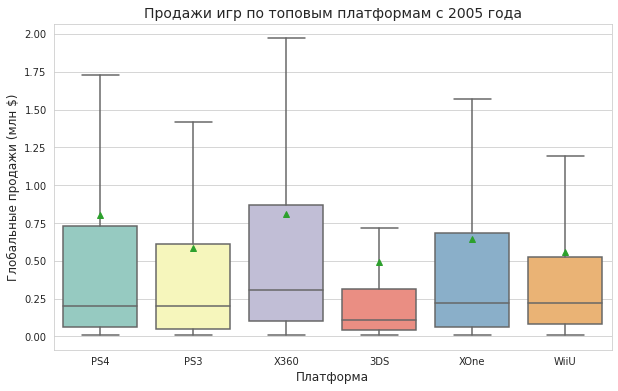

In [29]:
# Указываем топовые платформы
top_platforms = ['X360', 'PS3', 'WiiU', '3DS', 'XOne', 'PS4']

# Фильтруем данные для топовых платформ
filtered_data = data_since_2012[data_since_2012['platform'].isin(top_platforms)]

# Сортируем платформы по убыванию глобальных продаж
sorted_platforms = filtered_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index

# Настройка размера фигуры
plt.figure(figsize=(10, 6))

# Построение боксплота с отсортированными платформами
sns.boxplot(data=filtered_data, y='total_sales', x='platform', order=sorted_platforms, showfliers=False, showmeans=True, palette="Set3")

# Настройка заголовков и меток осей
plt.title('Продажи игр по топовым платформам с 2005 года', fontsize=14)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи (млн $)', fontsize=12)

# Отображение графика
plt.show()

Медианная сумма продаж по топовым платформам варьируется от 0,15 до 0,28 млн за игру. Верхняя граница боксплота, за которыми находятся выбросы, у платформы X360 - на уровне 1,95 млн. У PS4, PS3, Xone - от 1,4 до 1,7 млн  , у WiiU около 1,2 млн, а у 3DS около 0,7. Медианы всех платформ лежат в пределах 0,12 - 0,28 млн. Все значения средних значительно больше медиан, значит на каждой платформе есть аномально высокие продажи некоторых игр.

<a id="3.6"></a>
Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Для этого напишем функцию.

In [30]:
def plot_sales_correlation(platform, data):
    # Фильтруем данные только для указанной платформы и удаляем строки с отсутствующими значениями отзывов
    platform_data = data[data['platform'] == platform].dropna(subset=['critic_score', 'user_score'])

    # Создаем сетку для двух графиков
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Первый график: диаграмма рассеяния для оценок критиков и продаж
    sns.scatterplot(data=platform_data, x='critic_score', y='total_sales', label='Оценка критиков', ax=axes[0])
    axes[0].set_title(f'Продажи игр на платформе {platform}\nи отзывы критиков')
    axes[0].set_xlabel('Оценки критиков')
    axes[0].set_ylabel('Глобальные продажи (млн $)')
    axes[0].legend()

    # Второй график: диаграмма рассеяния для оценок пользователей и продаж
    sns.scatterplot(data=platform_data, x='user_score', y='total_sales', label='Оценка пользователей', ax=axes[1])
    axes[1].set_title(f'Продажи игр на платформе {platform}\nи отзывы пользователей')
    axes[1].set_xlabel('Оценки пользователей')
    axes[1].set_ylabel('Глобальные продажи (млн $)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Вычисление корреляции между отзывами и продажами
    critic_corr = platform_data['critic_score'].corr(platform_data['total_sales'])
    user_corr = platform_data['user_score'].corr(platform_data['total_sales'])

    print("Корреляция между отзывами критиков и продажами на платформе", platform, ":", critic_corr)
    print("Корреляция между отзывами пользователей и продажами на платформе", platform, ":", user_corr)

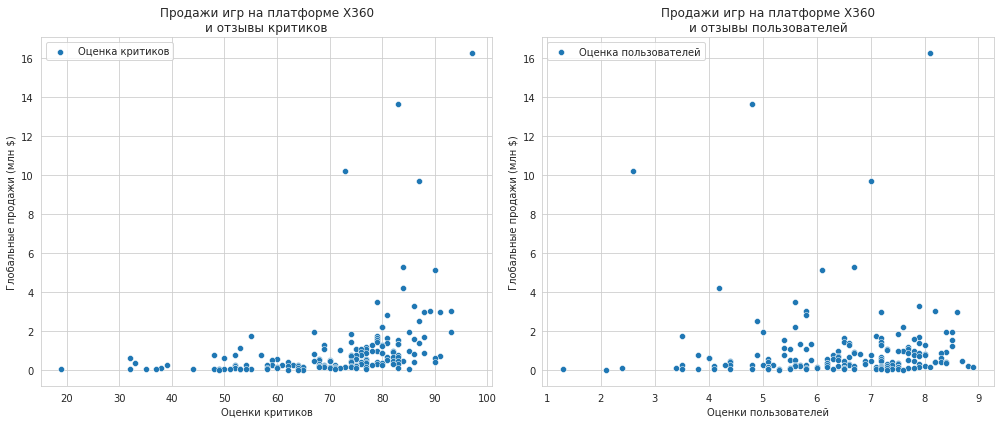

Корреляция между отзывами критиков и продажами на платформе X360 : 0.3605734888507336
Корреляция между отзывами пользователей и продажами на платформе X360 : -0.0020140394826897853


In [31]:
# Используем функцию для платформы X360
plot_sales_correlation('X360', data_since_2012)

Мы наблюдаем небольшую корреляцию между продажами и оценками критиков. Если по оценкам критиков можно проследить небольшое влияние на продажи, то в случае с оценками пользователей корреляция слишком мала, еще и обратная.

Соотнесем выводы с продажами игр на других платформах из top_selling_platforms и построим такие же графики для других платформ из топ-6.

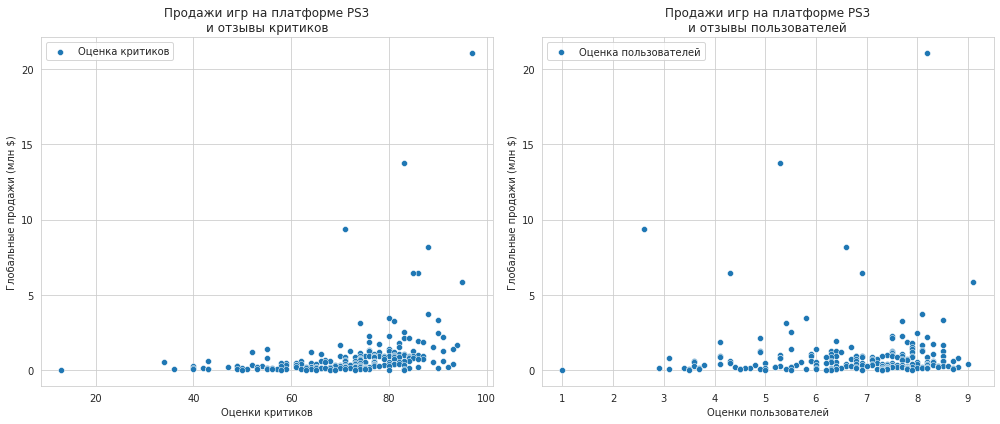

Корреляция между отзывами критиков и продажами на платформе PS3 : 0.3310566175801407
Корреляция между отзывами пользователей и продажами на платформе PS3 : 0.00322740549303569


In [32]:
# Используем функцию для платформы PS3
plot_sales_correlation('PS3', data_since_2012)

На платформе PS3 так же есть небольшая корреляция между продажами и оценками критиков, от ценок пользователей связи с продажами не видим.

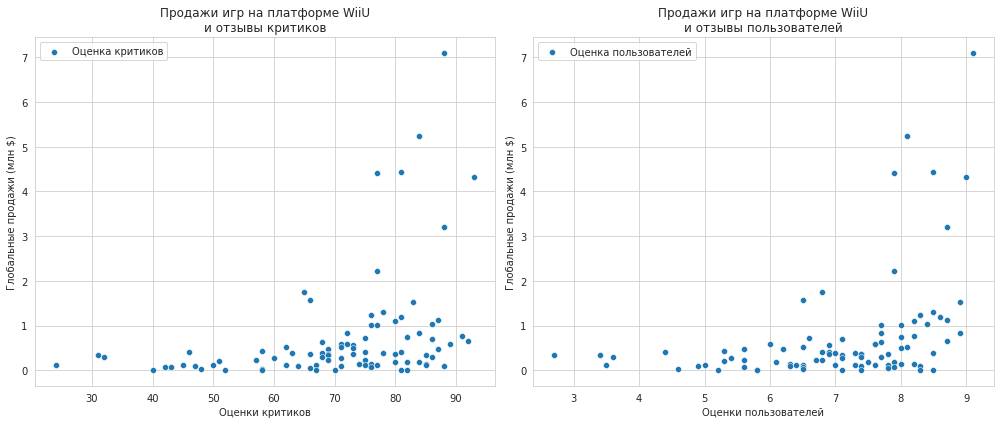

Корреляция между отзывами критиков и продажами на платформе WiiU : 0.350882422488643
Корреляция между отзывами пользователей и продажами на платформе WiiU : 0.3918479505297129


In [33]:
# Используем функцию для платформы WiiU
plot_sales_correlation('WiiU', data_since_2012)

Для платформы WiiU коэфициент корреляции критиков сильно снизилсяи пользователей примерно одинаковый и даже зависимость от оценок пользователей несколько выше. 

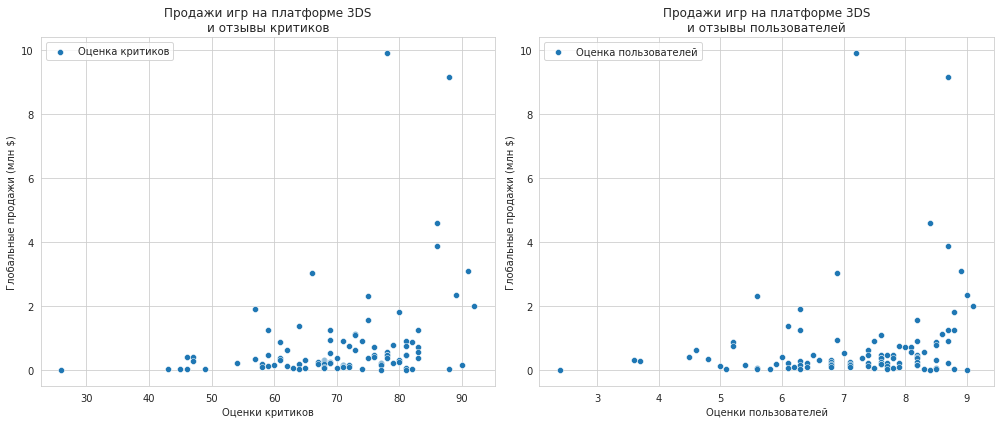

Корреляция между отзывами критиков и продажами на платформе 3DS : 0.31055301915326294
Корреляция между отзывами пользователей и продажами на платформе 3DS : 0.20181255007655283


In [34]:
# Используем функцию для платформы 3DS
plot_sales_correlation('3DS', data_since_2012)

На диаграмме платформы 3DS видна небольная зависимость продаж от оценок критиков и пользователей. 

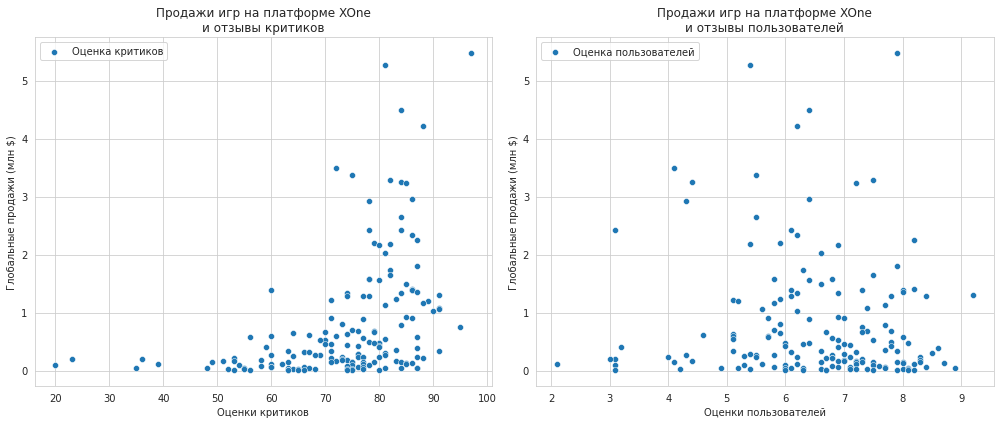

Корреляция между отзывами критиков и продажами на платформе XOne : 0.41042203561296375
Корреляция между отзывами пользователей и продажами на платформе XOne : -0.09400318326920852


In [35]:
# Используем функцию для платформы XOne
plot_sales_correlation('XOne', data_since_2012)

Наблюдаем самый высоких из исследуемых коэфициент зависимости продаж от ценок критиков у платформы XOne. С оценками пользователей картина обратная.

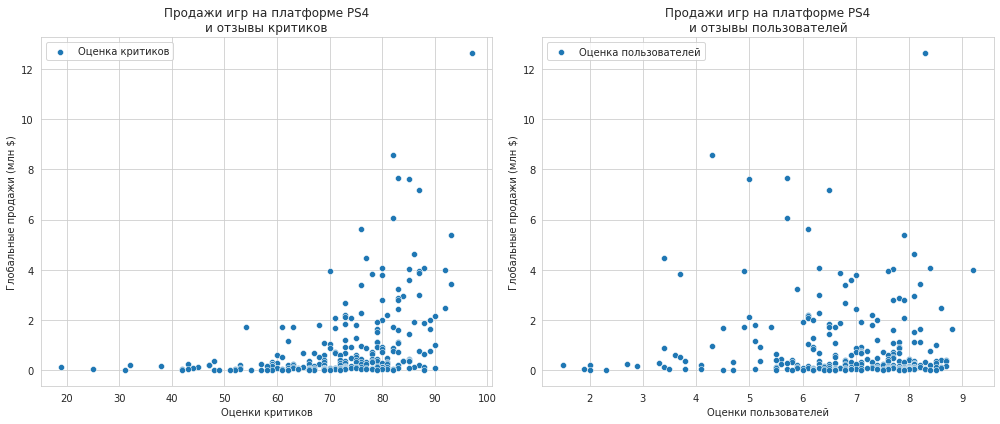

Корреляция между отзывами критиков и продажами на платформе PS4 : 0.40589480145836687
Корреляция между отзывами пользователей и продажами на платформе PS4 : -0.03362497596528878


In [36]:
# Используем функцию для платформы PS4
plot_sales_correlation('PS4', data_since_2012)

Похожая картина по платформе XOne.

В целом по результатам анализа корреляции продаж от оценок, можно сказать что большая зависимость продаж наблюдается от оценок критиков, чем выше оценки, тем выше продажи.  В то время как можно сказать, что зависимость продаж от оценок пользователей отсутствует.

In [37]:
data_since_2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2886 entries, 0 to 2885
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            2886 non-null   int64  
 1   name             2886 non-null   object 
 2   platform         2886 non-null   object 
 3   year_of_release  2886 non-null   Int64  
 4   genre            2886 non-null   object 
 5   na_sales         2886 non-null   float64
 6   eu_sales         2886 non-null   float64
 7   jp_sales         2886 non-null   float64
 8   other_sales      2886 non-null   float64
 9   critic_score     1312 non-null   float64
 10  user_score       1531 non-null   float64
 11  rating           1611 non-null   object 
 12  total_sales      2886 non-null   float64
dtypes: Int64(1), float64(7), int64(1), object(4)
memory usage: 296.1+ KB


<a id="3.7"></a>
Посмотрим на общее распределение игр по жанрам по количеству и по сумме продаж.

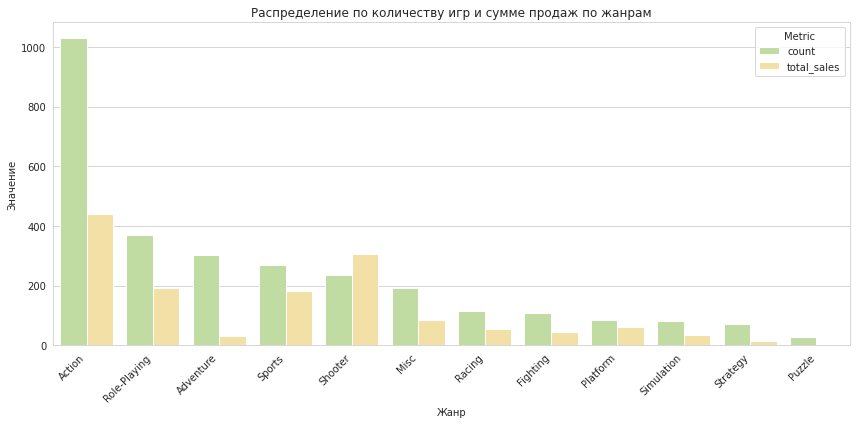

In [38]:
# Группировка данных по жанрам и подсчет количества игр в каждом жанре
genre_counts = data_since_2012['genre'].value_counts().reset_index().rename(columns={'index': 'genre', 'genre': 'count'})

# Группировка данных по жанрам и суммирование глобальных продаж для каждого жанра
genre_sales = data_since_2012.groupby('genre')['total_sales'].sum().sort_values(ascending=False).reset_index()

# Объединение данных о количестве игр и суммарных продажах
genre_data = pd.merge(genre_counts, genre_sales, on='genre')

# Сортировка данных по убыванию количества игр
genre_data = genre_data.sort_values(by='count', ascending=False)

# Создание графика 
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_data.melt(id_vars='genre', var_name='Metric', value_name='Value'), x='genre', y='Value', hue='Metric', palette=['#c2e699', '#ffe699'])
plt.title('Распределение по количеству игр и сумме продаж по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Значение')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

На графике мы видим, что самое большое количество игр в жанре Action. Так же у этого жанра самые высокие суммы продаж. Далее по двум параметрам также идет жанр Sports. У жанра Shooter самое хорошее соотношение количества продаж к выручке. Самые малочисленные по продажам и выручке жанры - Strategi и Puzzle, жанры спокойного типа, тогда как на вершине списка активные жанры.

Поскольку высокие продажи могут быть вызваны не успехом, а просто огромным количеством игр, рассмотрим средние показатели продаж. Посторим бокплоты и посмотрим на распределение продаж по жанрам.

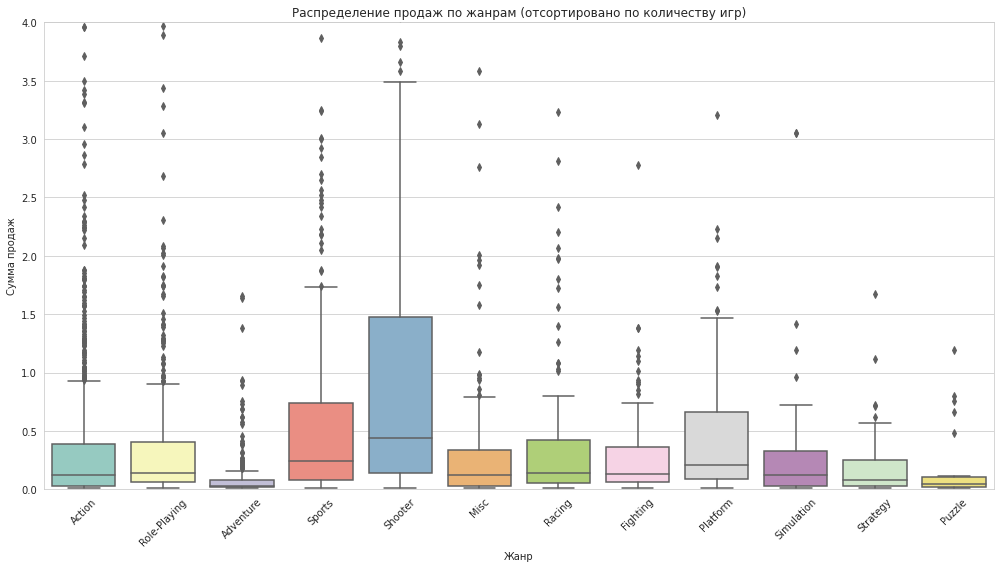

In [39]:
# Сортировка данных по количеству игр
sorted_genres_by_game_count = genre_counts.sort_values(by='count', ascending=False)['genre']

# Создание боксплота с отсортированными жанрами
plt.figure(figsize=(14, 8))
sns.boxplot(x='genre', y='total_sales', data=data_since_2012, order=sorted_genres_by_game_count, palette='Set3')
plt.title('Распределение продаж по жанрам (отсортировано по количеству игр)')
plt.xlabel('Жанр')
plt.ylabel('Сумма продаж')
plt.xticks(rotation=45)
plt.ylim(0, 4)  # Ограничение оси y
plt.tight_layout()
plt.show()

В жанре Action очень много выбросов, значит много аномально прибыльных игр было выпущено, отсюда и самая высока доходность жанра. Медианное значение продаж самое высокое в жанре Shooter. Второе место по медианным продажам делят Platform и Sports, самое маленькое у Adventure.

<a id="3.8"></a>
В ходе исследователького анализа данных мы изучили количество игр, которые выпускались в разные годы. Выяснили, что до начала 1990-х годов индустрия развивалась очень слабо, далее начался активный рост и количество выпускаемых игр достигло своего пика в 2008-2009 годах. В 2012 случился резкий спад и к 2016 году этот показатель колеблится примерно на уровне 550 игр в год. Изучив топ-6 платформ мы выяснили, что срок активной «жизни»
платформ составляет примено 10 лет и на основе полученных выводой взяли за актуальный период исследования 12 лет с 2005 по 2016 года. Затем мы вывели топ-6 платформ по продажам в исследуемый период, ими оказались X360, PS3, Wii, DS, PS2,  PS4. Медианная сумма продаж по топовым платформам варьируется от 0,15 до 0,28 млн за игру. На каждой платформе есть аномально высокие продажи некоторых игр. Так же мы изучили влияние оценок критиков и пользователей на продажи. В целом по результатам анализа корреляции продаж от оценок, можно сказать что бОльшая зависимость продаж наблюдается от оценок критиков, чем выше оценки, тем выше продажи.  В то же время можно сказать, что зависимость продаж от оценок пользователей отсутствует. Рассмотрели распределение игр по жанрам по количеству и по сумме продаж, выяснив, что самое большое количество игр в жанре Action. Так же у этого жанра самые высокие суммы продаж.  И в целом более продаваемы оказались активные жанры игр, а менее - жанры спокойного типа (Strategi и Puzzle).

<a id="anal"></a> 
## Составим портрет пользователя каждого региона

<a id="4.1"></a>
Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5).

In [40]:
#data_since_2012_NA = 
# Группировка данных по платформам и суммирование продаж для каждого региона
na_platform_sales = data_since_2012.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_platform_sales = data_since_2012.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_platform_sales = data_since_2012.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

# Вывод топ-5 платформ для каждого региона
print("Топ-5 платформ в регионе NA:")
print(na_platform_sales)
print("\nТоп-5 платформ в регионе EU:")
print(eu_platform_sales)
print("\nТоп-5 платформ в регионе JP:")
print(jp_platform_sales)

Топ-5 платформ в регионе NA:
platform
X360   140.05
PS4    108.74
PS3    103.38
XOne    93.12
3DS     55.31
Name: na_sales, dtype: float64

Топ-5 платформ в регионе EU:
platform
PS4    141.09
PS3    106.86
X360    74.52
XOne    51.59
3DS     42.64
Name: eu_sales, dtype: float64

Топ-5 платформ в регионе JP:
platform
3DS    87.79
PS3    35.29
PSV    21.04
PS4    15.96
WiiU   13.01
Name: jp_sales, dtype: float64


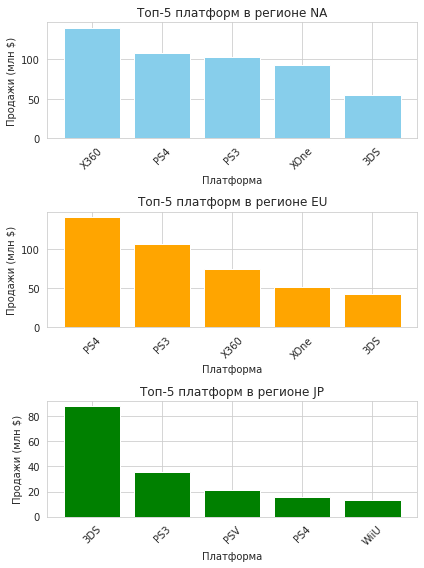

In [41]:
# Создание графиков
fig, axes = plt.subplots(3, 1, figsize=(6, 8))

# График для региона NA
axes[0].bar(na_platform_sales.index, na_platform_sales.values, color='skyblue')
axes[0].set_title('Топ-5 платформ в регионе NA')
axes[0].set_xlabel('Платформа')
axes[0].set_ylabel('Продажи (млн $)')
axes[0].tick_params(axis='x', rotation=45)

# График для региона EU
axes[1].bar(eu_platform_sales.index, eu_platform_sales.values, color='orange')
axes[1].set_title('Топ-5 платформ в регионе EU')
axes[1].set_xlabel('Платформа')
axes[1].set_ylabel('Продажи (млн $)')
axes[1].tick_params(axis='x', rotation=45)

# График для региона JP
axes[2].bar(jp_platform_sales.index, jp_platform_sales.values, color='green')
axes[2].set_title('Топ-5 платформ в регионе JP')
axes[2].set_xlabel('Платформа')
axes[2].set_ylabel('Продажи (млн $)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Выведем груговые диаграммы с распределение долей продаж по платфорам в регионах

In [42]:
# Суммарные продажи по регионам
total_na_sales = data_since_2012['na_sales'].sum()
total_eu_sales = data_since_2012['eu_sales'].sum()
total_jp_sales = data_since_2012['jp_sales'].sum()

# Вычисление долей продаж для каждой платформы в каждом регионе
na_platform_sales_share = na_platform_sales / total_na_sales * 100
eu_platform_sales_share = eu_platform_sales / total_eu_sales * 100
jp_platform_sales_share = jp_platform_sales / total_jp_sales * 100

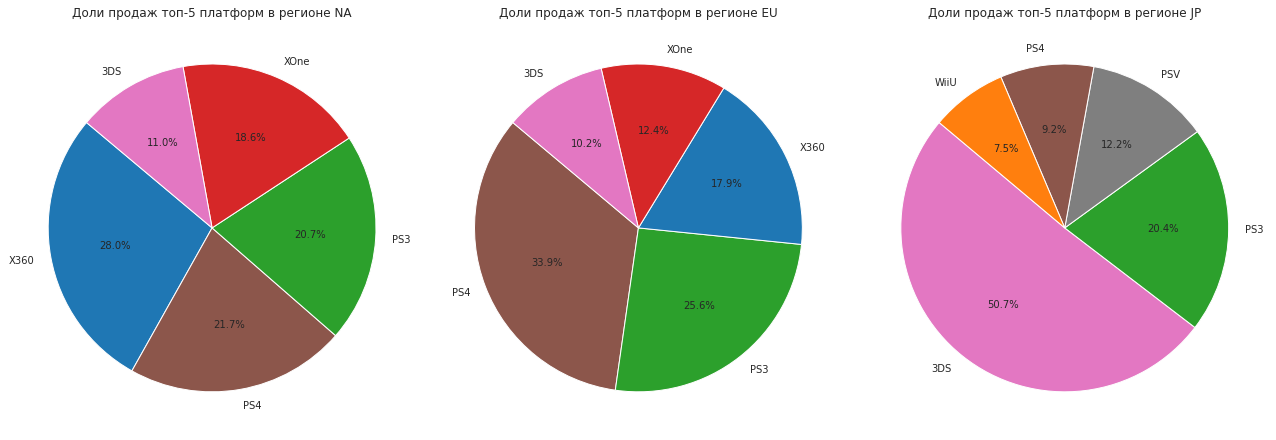

In [43]:
# Создание словаря для сопоставления платформ и цветов
platform_colors = {
    'X360': 'tab:blue',
    'WiiU': 'tab:orange',
    'PS3': 'tab:green',
    'XOne': 'tab:red',
    'PS2': 'tab:purple',
    'PS4': 'tab:brown',
    '3DS': 'tab:pink',
    'PSV': 'tab:gray'
    # Добавьте другие платформы и цвета при необходимости
}

# Создание сетки с 1 строкой и 3 столбцами для размещения круговых диаграмм
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Данные для построения круговых диаграмм
na_platforms = na_platform_sales_share.index
na_sales_share = na_platform_sales_share.values

eu_platforms = eu_platform_sales_share.index
eu_sales_share = eu_platform_sales_share.values

jp_platforms = jp_platform_sales_share.index
jp_sales_share = jp_platform_sales_share.values

# Построение круговой диаграммы для региона NA
axes[0].pie(na_sales_share, labels=na_platforms, autopct='%1.1f%%', startangle=140, colors=[platform_colors[p]\
                                                                                            for p in na_platforms])
axes[0].set_title('Доли продаж топ-5 платформ в регионе NA')

# Построение круговой диаграммы для региона EU
axes[1].pie(eu_sales_share, labels=eu_platforms, autopct='%1.1f%%', startangle=140, colors=[platform_colors[p]\
                                                                                            for p in eu_platforms])
axes[1].set_title('Доли продаж топ-5 платформ в регионе EU')

# Построение круговой диаграммы для региона JP
axes[2].pie(jp_sales_share, labels=jp_platforms, autopct='%1.1f%%', startangle=140, colors=[platform_colors[p]\
                                                                                            for p in jp_platforms])
axes[2].set_title('Доли продаж топ-5 платформ в регионе JP')

# Отображение сетки с круговыми диаграммами
plt.tight_layout()
plt.show()

Картина в NA и EU схожа, наблюдаются пять одинаковых лидера продаж - X360, PS4, PS3, XOne и 3DS. Различие лишь в распределении мест в тройке. У JP несколько другая история, явный лидер - 3DS, на втором месте PS3, так же присутствуют платформы PSV и WiiU, которых мы не наблюдали в EU и NA. 

<a id="4.2"></a>
Определим самые популярные жанры (топ-5)

In [44]:
# Группировка данных по жанрам и суммирование продаж для каждого региона
na_genre_sales = data_since_2012.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_genre_sales = data_since_2012.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_genre_sales = data_since_2012.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

# Вывод топ-5 жанров для каждого региона
print("Топ-5 жанров в регионе NA:")
print(na_genre_sales)
print("\nТоп-5 жанров в регионе EU:")
print(eu_genre_sales)
print("\nТоп-5 жанров в регионе JP:")
print(jp_genre_sales)

Топ-5 жанров в регионе NA:
genre
Action         177.84
Shooter        144.77
Sports          81.53
Role-Playing    64.00
Misc            38.19
Name: na_sales, dtype: float64

Топ-5 жанров в регионе EU:
genre
Action         159.34
Shooter        113.47
Sports          69.09
Role-Playing    48.53
Racing          27.29
Name: eu_sales, dtype: float64

Топ-5 жанров в регионе JP:
genre
Role-Playing   65.44
Action         52.80
Misc           12.86
Simulation     10.41
Fighting        9.44
Name: jp_sales, dtype: float64


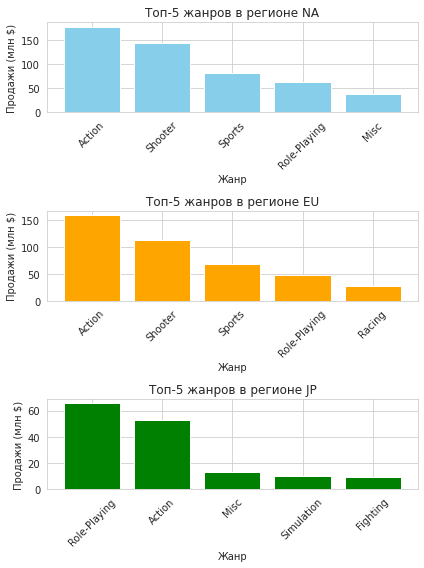

In [45]:
# Создание графиков
fig, axes = plt.subplots(3, 1, figsize=(6, 8))

# График для топ-5 жанров в регионе NA
axes[0].bar(na_genre_sales.index, na_genre_sales.values, color='skyblue')
axes[0].set_title('Топ-5 жанров в регионе NA')
axes[0].set_xlabel('Жанр')
axes[0].set_ylabel('Продажи (млн $)')
axes[0].tick_params(axis='x', rotation=45)

# График для топ-5 жанров в регионе EU
axes[1].bar(eu_genre_sales.index, eu_genre_sales.values, color='orange')
axes[1].set_title('Топ-5 жанров в регионе EU')
axes[1].set_xlabel('Жанр')
axes[1].set_ylabel('Продажи (млн $)')
axes[1].tick_params(axis='x', rotation=45)

# График для топ-5 жанров в регионе JP
axes[2].bar(jp_genre_sales.index, jp_genre_sales.values, color='green')
axes[2].set_title('Топ-5 жанров в регионе JP')
axes[2].set_xlabel('Жанр')
axes[2].set_ylabel('Продажи (млн $)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

В NA и EU самые популярные активные и захватывающие жанры игр - Action, Shooter,Sports. В JP это ролевые игры, Action на втором месте.

<a id="4.3"></a>
Посмотрим, влияет ли рейтинг ESRB на продажи в отдельном регионе?

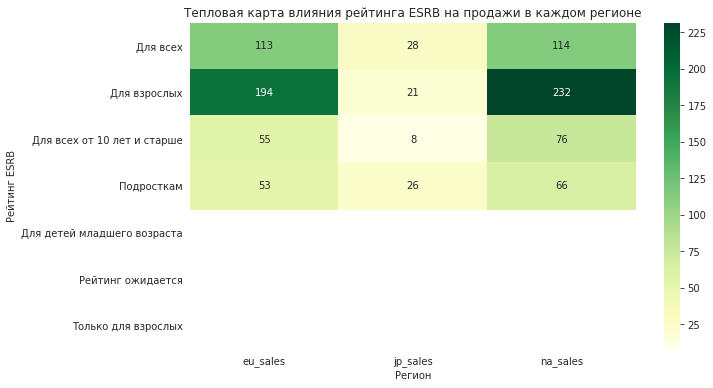

In [46]:
# Удаление строк с пропущенными значениями в столбце 'rating'
rating_sales = data_since_2012.dropna(subset=['rating'])

# Построение матрицы корреляции между рейтингом ESRB и продажами в каждом регионе
correlation_matrix = rating_sales[['na_sales', 'eu_sales', 'jp_sales', 'rating']].pivot_table(index='rating', aggfunc='sum')

# Сортировка значений индекса по желаемому порядку
desired_order = ['Для всех', 'Для взрослых', 'Для всех от 10 лет и старше', 'Подросткам', 'Для детей младшего возраста', 'Рейтинг ожидается', 'Только для взрослых']
correlation_matrix = correlation_matrix.reindex(desired_order)

# Построение тепловой карты с измененным порядком значений рейтинга
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGn', fmt=".0f")
plt.title('Тепловая карта влияния рейтинга ESRB на продажи в каждом регионе')
plt.xlabel('Регион')
plt.ylabel('Рейтинг ESRB')
plt.show()

Тепловая карта наглядно показывает, что в NA и  EU картина одинаковая. Лучше всего продаются фильмы категории "Для взрослых", на втором месте категория "Для всех", на третьем -  "Для всех от 10 лет и старше", а на четвертом - "Подросткам". В Японии же на первом месте - "Для всех", на втором - "Для взрослых", на третьем "Подросткам". Категории для детей младшего возраста правктически не встречаются.

<a id="4.4"></a>
- Портрет пользователя региона Северной Америки: Самая оппулярная платформа Х360, доля продаж которой составляет 28 %,  следующая по популярности PS4, доля продаж — 21,7%, так же примерно одинаково продаются PS3 и XOne и замыкает топ-5 3DS – 11 %. Самый популярный игровой жанр — Action, далее Shooter и Sport- активные, захватывающие. По возрастным категория лидируют игры «Для взрослых»

- Портрет пользователя региона Европы: Самая популярная платформа PS4, доля продаж которой составляет 33,9%,  следующая по популярности PS3, доля продаж — 25,6%, далее Х360 и XOne и замыкает топ-5 3DS – 10,2%. Самый популярный игровой жанр — Action, далее Shooter и Sport- активные, захватывающие.По возрастным категория лидируют игры «Для взрослых».

- Портрет пользователя региона Японии: Самая оппулярная платформа 3DS, доля продаж которой составляет 50,7%,  следующая по популярности PS3, доля продаж — 20,4%, так же примерно одинаково продаются PS4 и PSV и замыкает топ-5 WiiU – 7,5%. Самый популярный игровой жанр — Role-Playing, далее Action.По возрастным категория лидируют игры «Для всех».

<a id="gypo"></a> 
## Проверка гипотез

<a id="5.1"></a>
Нам предстроить проверить гипотезы:

Гипотеза первая : Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем нулевую гипотезу (H0): Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Сформулируем альтернативную гипотезу (H1): Средние пользовательские рейтинги платформ Xbox One и PC различаются
Выберем уровень значимости (α) 0.05
Используем t-тест для независимых выборок

In [47]:
# Фильтрация данных по платформам Xbox One и PC и удаление пропущенных значений пользовательского рейтинга
xbox_scores = data_since_2012[(data_since_2012['platform'] == 'XOne') & (~data_since_2012['user_score']\
                                                                         .isnull())]['user_score']
pc_scores = data_since_2012[(data_since_2012['platform'] == 'PC') & (~data_since_2012['user_score']\
                                                                     .isnull())]['user_score']
# Проведение t-теста
t_statistic, p_value = st.ttest_ind(xbox_scores, pc_scores)

# Уровень значимости
alpha = 0.05

# Вывод результатов
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC различаются.")
else:
    print("Не отвергаем нулевую гипотезу: нет достаточных доказательств различия средних пользовательских рейтингов\
    платформ Xbox One и PC.")

Не отвергаем нулевую гипотезу: нет достаточных доказательств различия средних пользовательских рейтингов    платформ Xbox One и PC.


Для проверки гипотезы о равенстве средних пользовательских рейтингов платформ Xbox One и PC был использован t-тест для независимых выборок. Этот критерий выбран потому, что он позволяет сравнивать средние значения двух независимых выборок, что соответствует нашей задаче, где мы сравниваем пользовательские рейтинги двух разных платформ.

Параметр alpha был выбран равным 0.05, что является общепринятым уровнем значимости. Результаты теста  не позволили нам сделать вывод о том, что существуют статистически значимые различия между средними пользовательскими рейтингами платформ Xbox One и PC, так как p-value (вероятность ошибки при отклонении нулевой гипотезы) оказалось больше выбранного уровня значимости alpha.

<a id="5.2"></a>
Гипотеза вторая: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Сформулируем нулевую гипотезу (H0): Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые
Сформулируем альтернативную гипотезу (H1): Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные
Выберем уровень значимости (α) 0.05
Используем t-тест для независимых выборок

In [48]:
# Фильтрация данных по жанрам Action и Sports и удаление пропущенных значений пользовательского рейтинга
action_scores = data_since_2012[(data_since_2012['genre'] == 'Action') & (~data_since_2012['user_score']\
                                                                          .isnull())]['user_score']
sports_scores = data_since_2012[(data_since_2012['genre'] == 'Sports') & (~data_since_2012['user_score']\
                                                                          .isnull())]['user_score']
# Проведение t-теста
t_statistic, p_value = st.ttest_ind(action_scores, sports_scores)

# Уровень значимости
alpha = 0.05

# Вывод результатов
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средние пользовательские рейтинги жанров Action и Sports различаются.")
else:
    print("Не отвергаем нулевую гипотезу: нет достаточных доказательств различия средних пользовательских\
    рейтингов жанров Action и Sports.")

Отвергаем нулевую гипотезу: средние пользовательские рейтинги жанров Action и Sports различаются.


Для проверки гипотезы о различии средних пользовательских рейтингов жанров Action и Sports был также использован t-тест для независимых выборок. Этот критерий был выбран потому, что мы сравниваем средние значения двух независимых выборок (пользовательские рейтинги двух разных жанров) из одной и той же генеральной совокупности (игровых данных с жанрами Action и Sports).

Параметр alpha был выбран равным 0.05, что является общепринятым уровнем значимости. Результаты теста позволили нам сделать вывод о том, что существуют статистически значимые различия между средними пользовательскими рейтингами жанров Action и Sports, так как p-value (вероятность ошибки при отклонении нулевой гипотезы) оказалось меньше выбранного уровня значимости alpha.

Таким образом, отвергаем нулевую гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports.

<a id="end"></a> 
## Вывод

В ходе проекта мы анализировали исторические данные о продажах игр, влияние оценок пользователей и экспертов, исследовали популярные игровые платформы и жанры в трех регионах (NA, ER, JP). По результатам анализа можно сделать следуюшие выводы:

На первом этапе работы мы ознаокмились с данными, в нашем распоряжении оказался датасет из 11 столбцов и 16713 строк с данными за период с 1980 по 2016 года. 

На этапе предобработки мы заменили типы данных в столбцах user_score и year_of_release, привели название столбцов и значения столбца name к нижнему регистру. Изменили значения столбца rating для наглядности дальнейшего анализа. Так же мы добавили новый столбец rating с суммарными продажами по играм во всех регионах. Поработали над пропусками. 


На этапе исследователького анализа мы изучили количество игр, которые выпускались в разные годы. Выяснили, что до начала 1990-х годов индустрия развивалась очень слабо, далее начался активный рост и количество выпускаемых игр достигло своего пика в 2008-2009 годах. В 2012 случился резкий спад и к 2016 году этот показатель колеблится примерно на уровне 550 игр в год. Изучив топ-6 платформ мы выяснили, что срок активной «жизни» платформ составляет примено 10 лет и взяли за актуальный период исследования 5 лет с 2012 по 2016 года. Топ-6 платформ по продажам в исследуемый период, ими оказались PS4,  PS3, X360,3DS, Xone,WiiU. Выяснили, что в целом бОльшая зависимость продаж наблюдается от оценок критиков, чем выше оценки, тем выше продажи. А  зависимость продаж от оценок пользователей отсутствует. Рассмотрели распределение игр по жанрам по количеству и по сумме продаж, выяснив, что самое большое количество игр в жанре Action. Так же у этого жанра самые высокие суммы продаж. Но медианное значение продаж самое высокое в жанре Shooter.  И в целом более продаваемы оказались активные жанры игр, а менее - жанры спокойного типа (Strategi и Puzzle). 


На четвером этапе исследования мы создали портреты пользователей разных регионов. 

- Портрет пользователя региона Северной Америки: Самая оппулярная платформа Х360, доля продаж которой составляет 28 %,  следующая по популярности PS4, доля продаж — 21,7%, так же примерно одинаково продаются PS3 и XOne и замыкает топ-5 3DS – 11 %. Самый популярный игровой жанр — Action, далее Shooter и Sport- активные, захватывающие. По возрастным категория лидируют игры «Для взрослых»

- Портрет пользователя региона Европы: Самая популярная платформа PS4, доля продаж которой составляет 33,9%,  следующая по популярности PS3, доля продаж — 25,6%, далее Х360 и XOne и замыкает топ-5 3DS – 10,2%. Самый популярный игровой жанр — Action, далее Shooter и Sport- активные, захватывающие.По возрастным категория лидируют игры «Для взрослых».

- Портрет пользователя региона Японии: Самая оппулярная платформа 3DS, доля продаж которой составляет 50,7%,  следующая по популярности PS3, доля продаж — 20,4%, так же примерно одинаково продаются PS4 и PSV и замыкает топ-5 WiiU – 7,5%. Самый популярный игровой жанр — Role-Playing, далее Action.По возрастным категория лидируют игры «Для всех».


На этапе проверки гипотез мы провели t-тесты, результатом которых стали выводы о том, что нет достаточных доказательств различия в средних пользовательских рейтингах платформ Xbox One и PC, а средние пользовательские рейтинги жанров Action и Sports  различаются.


Определяющие успешность игры закономерности получились несколько разными для разных регионов. Чтобы спланировать рекламные кампании, нужно понимать особенности предпочтений того или иного региона. Так, например, пользователи Европейских стран предпочитают игры в жанре Action, Sport, Shooter. Вкусы к жанрам у Северной Америки схожи – это так же Action и Sport. А вот пользователи из Японии предпочитают более спокойные и интеллектуальные жанры, такие как Strategi и Puzzle. По возрастным категориям, конечно, более продаваемы игр «Для всех» без ограничения возраста пользователя. Абсолютно провальной в каждом регионе является категория игр для детей до 10 лет, такое впечатление, что дети до 10 лет не играют в компьютерные игры. Может стоит поработать над рекламой игр для этой возрастной категории. 

Что же касается игровых платформ, то перспективными на конец 2016 года, платформы, которые еще не прожили свой цикл, видятся такие платформы как : PS4 (компания sony постоянно присутствует на рынке со своими продуктами, которые заменяют друг друга с течением времени), которые наиболее популярны в Европе, но и в других регионах так же входят в топ популярных платформ;  Xone от Microsoft, еще наберет свою популярность в Европе и Северной Америке. А вот в Японии, соответственно, более популярны свои платформы и на конец 2016 года видится перспективной  3DS от компании Nintendo.
